# Titanic: Machine Learning from Disaster

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using TensorFlow backend.


## Exploring the Data

In [2]:
# load data
train = pd.read_csv('../datasets/titanic-train.csv')
test = pd.read_csv('../datasets/titanic-test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data Cleaning and Features Choosing

In [4]:
# get_dummies function
def dummies(col,train,test):
    train_dum = pd.get_dummies(train[col])
    test_dum = pd.get_dummies(test[col])
    train = pd.concat([train, train_dum], axis=1)
    test = pd.concat([test,test_dum],axis=1)
    train.drop(col,axis=1,inplace=True)
    test.drop(col,axis=1,inplace=True)
    return train, test

In [5]:
# get rid of the useless cols
dropping = ['PassengerId', 'Name', 'Ticket']
train.drop(dropping, axis=1, inplace=True)
test.drop(dropping, axis=1, inplace=True)

### Attribute PClass

3    491
1    216
2    184
Name: Pclass, dtype: int64


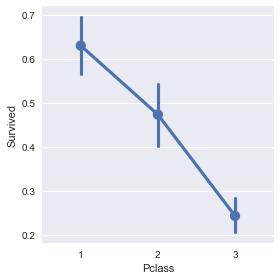

In [6]:
# ensure no na contained
print(train['Pclass'].value_counts(dropna=False))
sns.factorplot('Pclass', 'Survived', data=train, order=[1,2,3])

# according to the graph, we found there are huge differences between
# each pclass group. keep the ft
train, test = dummies('Pclass', train, test)

### Attribute Sex

male      577
female    314
Name: Sex, dtype: int64


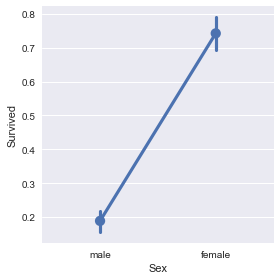

In [7]:
print(train['Sex'].value_counts(dropna=False))
sns.factorplot('Sex', 'Survived', data=train)

# female survival rate is way better than the male
train, test = dummies('Sex', train, test)
# cos the male survival rate is so low, delete the male col
train.drop('male', axis=1, inplace=True)
test.drop('male', axis=1, inplace=True)

### Attribute Age

C:\Users\Redheads\Anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Redheads\Anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


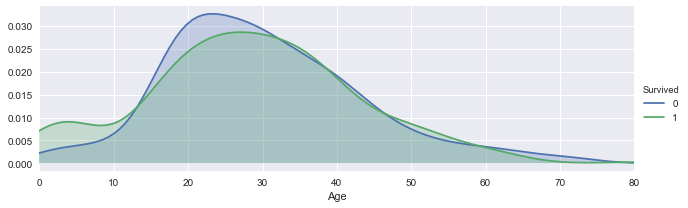

In [8]:
#dealing the missing data
nan_num = train['Age'].isnull().sum()
# there are 177 missing value, fill with random int
age_mean = train['Age'].mean()
age_std = train['Age'].std()
filling = np.random.randint(age_mean-age_std, age_mean+age_std, size=nan_num)
train['Age'][train['Age'].isnull()==True] = filling
nan_num = train['Age'].isnull().sum()

# dealing the missing val in test
nan_num = test['Age'].isnull().sum()
# 86 null
age_mean = test['Age'].mean()
age_std = test['Age'].std()
filling = np.random.randint(age_mean-age_std,age_mean+age_std,size=nan_num)
test['Age'][test['Age'].isnull()==True]=filling
nan_num = test['Age'].isnull().sum()

#look into the age col
s = sns.FacetGrid(train,hue='Survived',aspect=3)
s.map(sns.kdeplot,'Age',shade=True)
s.set(xlim=(0,train['Age'].max()))
s.add_legend()

# from the graph, we see that the survival rate of children
# is higher than other and the 15-30 survival rate is lower
def under15(row):
    result = 0.0
    if row<15:
        result = 1.0
    return result
def young(row):
    result = 0.0
    if row>=15 and row<30:
        result = 1.0
    return result

train['under15'] = train['Age'].apply(under15)
test['under15'] = test['Age'].apply(under15)
train['young'] = train['Age'].apply(young)
test['young'] = test['Age'].apply(young)

train.drop('Age',axis=1,inplace=True)
test.drop('Age',axis=1,inplace=True)

### Attribute Family

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


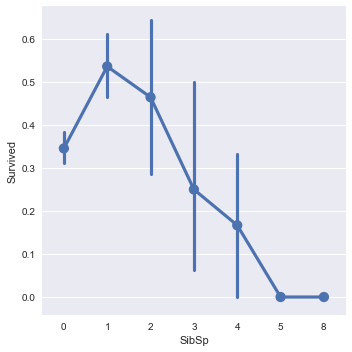

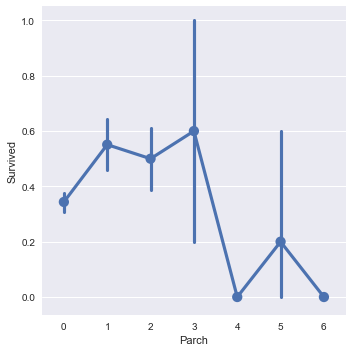

In [9]:
print(train['SibSp'].value_counts(dropna=False))
print(train['Parch'].value_counts(dropna=False))

sns.factorplot('SibSp','Survived',data=train,size=5)
sns.factorplot('Parch','Survived',data=train,size=5)

Through the plot, we suggest that with more family member, 
the survival rate will drop, we can create the new col
add up the parch and sibsp to check our theory

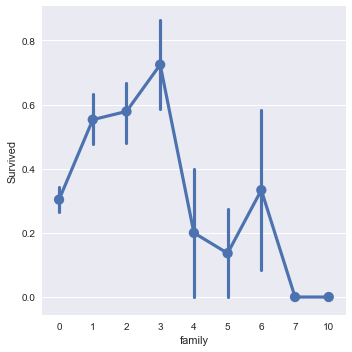

In [10]:
train['family'] = train['SibSp'] + train['Parch']
test['family'] = test['SibSp'] + test['Parch']
sns.factorplot('family','Survived',data=train,size=5)

train.drop(['SibSp','Parch'],axis=1,inplace=True)
test.drop(['SibSp','Parch'],axis=1,inplace=True)

### Attribute Fare

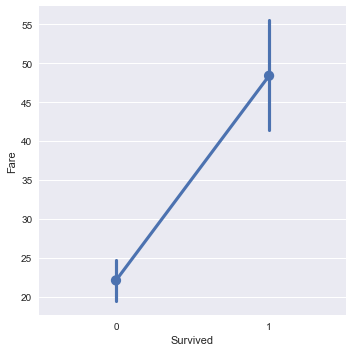

In [11]:
# checking null, found one in test group. leave it alone til we find out
# wether we should use this ft
train.Fare.isnull().sum()
test.Fare.isnull().sum()

sns.factorplot('Survived', 'Fare', data=train, size=5)
#according to the plot, smaller fare has higher survival rate, keep it
#dealing the null val in test
test['Fare'].fillna(test['Fare'].median(), inplace=True)

### Attribute Cabin

In [12]:
# checking missing val
# 687 out of 891 are missing, drop this col
train.Cabin.isnull().sum()
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

### Attribute Embark

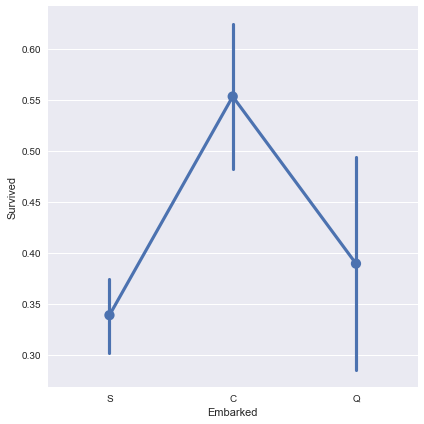

In [13]:
train.Embarked.isnull().sum()
# 2 missing value
train.Embarked.value_counts()
# fill the majority val,'s', into missing val col
train['Embarked'].fillna('S', inplace=True)

sns.factorplot('Embarked', 'Survived', data=train, size=6)
# c has higher survival rate, drop the other two
train, test = dummies('Embarked', train, test)
train.drop(['S', 'Q'], axis=1, inplace=True)
test.drop(['S', 'Q'], axis=1, inplace=True)

### Show final data set

In [14]:
train.head()

,Survived,Fare,1,2,3,female,under15,young,family,C
0,0,7.2500,0,0,1,0,0.0,1.0,1,0
1,1,71.2833,1,0,0,1,0.0,0.0,1,1
2,1,7.9250,0,0,1,1,0.0,1.0,0,0
3,1,53.1000,1,0,0,1,0.0,0.0,1,0
4,0,8.0500,0,0,1,0,0.0,0.0,0,0


In [15]:
train.describe()

,Survived,Fare,1,2,3,female,under15,young,family,C
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,32.204208,0.242424,0.206510,0.551066,0.352413,0.087542,0.447811,0.904602,0.188552
std,0.486592,49.693429,0.428790,0.405028,0.497665,0.477990,0.282787,0.497548,1.613459,0.391372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,31.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000


## Model and Prediction

In [16]:
def baseline_model():
    model = Sequential()
    
    model.add(Dense(9, input_dim=9, kernel_initializer='uniform'))
    model.add(Activation('sigmoid'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(20, kernel_initializer='uniform'))
    model.add(Activation('relu'))
    
    model.add(Dense(20, kernel_initializer='uniform'))
    model.add(Activation('sigmoid'))
    
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [17]:
batch_size = 5
epochs = 20

In [18]:
X_train = train.drop(['Survived'], axis=1).as_matrix()
y_train = train['Survived'].as_matrix()

In [21]:
model = baseline_model()

In [ ]:
# train the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)